In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import os
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE=32
CHANNELS=3
EPOCHS =25

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML/3types Lungs Disease",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3986 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal']

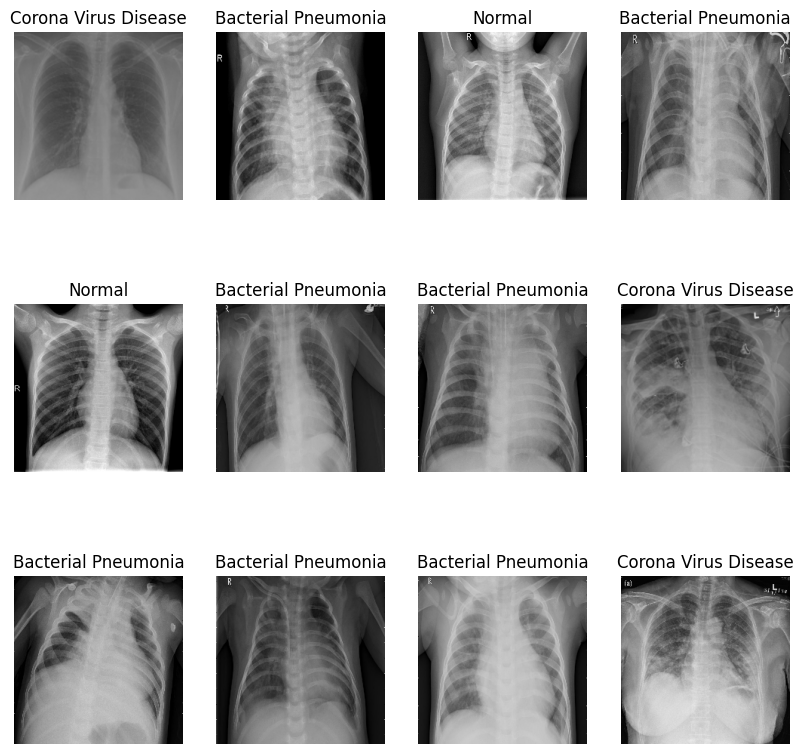

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

125

In [ ]:
train_size =0.8
len(dataset)*train_size

100.0

In [ ]:
train_ds = dataset.take(100)
len(train_ds)

100

In [ ]:
test_ds=dataset.skip(100) 
len(test_ds)

25

In [ ]:
val_size = 0.1
len(dataset)*val_size

12.5

In [ ]:
val_ds=test_ds.take(12)
len(val_ds)

12

In [ ]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):

  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds =ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds


In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

100

In [ ]:
len(val_ds)

12

In [ ]:
len(test_ds)

13

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

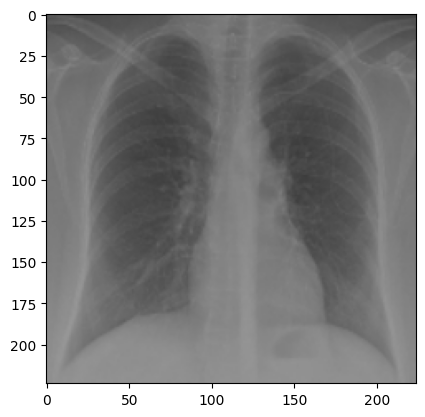

In [ ]:
img=plt.imshow(image_batch[0].numpy().astype("uint8"))

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/223)  
])


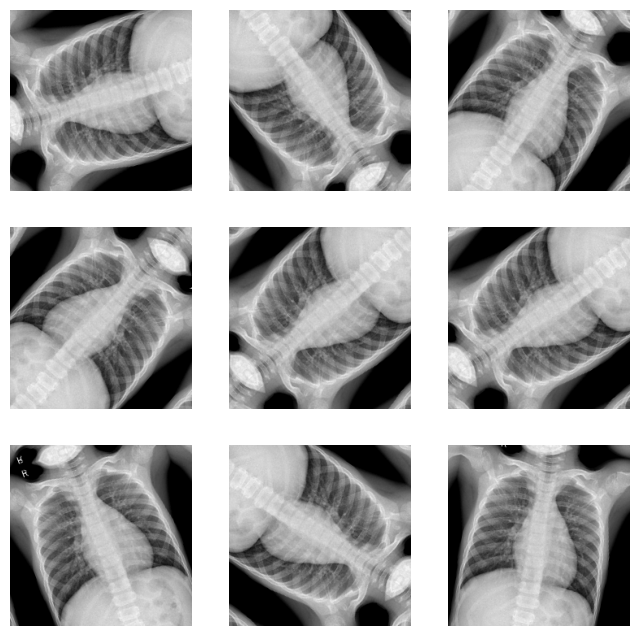

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(8,8))
for images, labels in test_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax=plt.subplot(3,3,i+1)

    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
input_shape=(BATCH_SIZE,  IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes =3
model= models.Sequential(
[
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)

Epoch 1/25
100/100 [==============================] - 102s 488ms/step - loss: 1.0361 - accuracy: 0.4363 - val_loss: 0.5276 - val_accuracy: 0.8177
Epoch 2/25
100/100 [==============================] - 5s 49ms/step - loss: 0.6289 - accuracy: 0.7247 - val_loss: 0.4109 - val_accuracy: 0.8828
Epoch 3/25
100/100 [==============================] - 5s 50ms/step - loss: 0.4450 - accuracy: 0.8371 - val_loss: 0.2954 - val_accuracy: 0.9193
Epoch 4/25
100/100 [==============================] - 5s 48ms/step - loss: 0.3585 - accuracy: 0.8663 - val_loss: 0.3728 - val_accuracy: 0.8516
Epoch 5/25
100/100 [==============================] - 5s 49ms/step - loss: 0.3120 - accuracy: 0.8792 - val_loss: 0.2667 - val_accuracy: 0.8880
Epoch 6/25
100/100 [==============================] - 5s 49ms/step - loss: 0.2789 - accuracy: 0.8892 - val_loss: 0.3819 - val_accuracy: 0.8542
Epoch 7/25
100/100 [==============================] - 5s 48ms/step - loss: 0.2692 - accuracy: 0.9011 - val_loss: 0.2232 - val_accuracy: 0.9

In [ ]:
scores1=model.evaluate(train_ds)

100/100 [==============================] - 2s 18ms/step - loss: 0.1406 - accuracy: 0.9517


In [ ]:
scores2=model.evaluate(test_ds)

13/13 [==============================] - 0s 20ms/step - loss: 0.1676 - accuracy: 0.9399


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 100}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

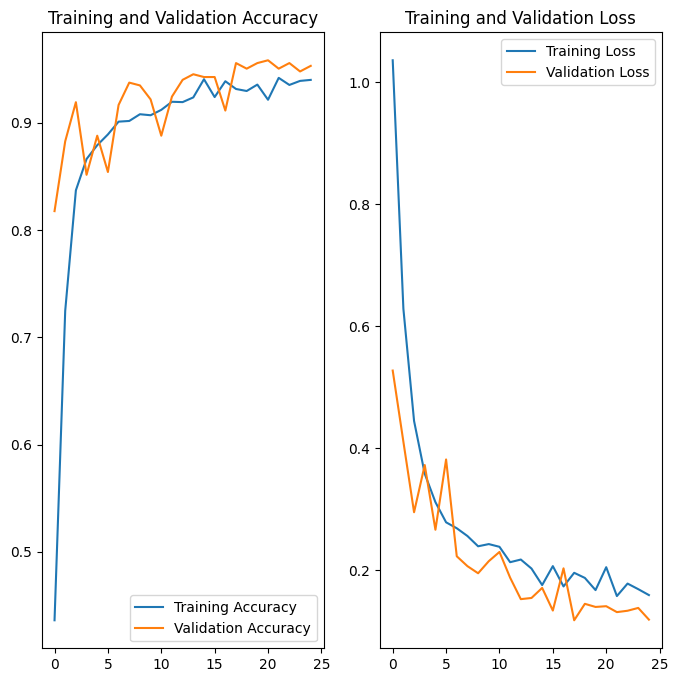

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

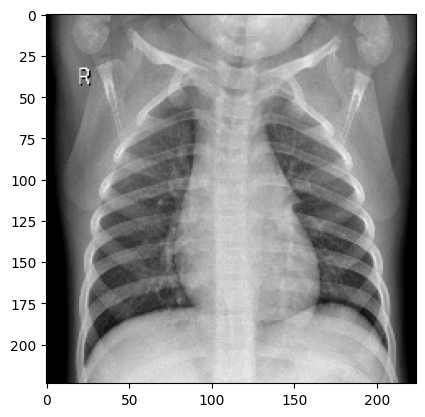

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  print(images_batch[0].numpy().astype('uint8'))

[[[200 200 200]
  [203 203 203]
  [196 196 196]
  ...
  [198 198 198]
  [189 189 189]
  [193 193 193]]

 [[197 197 197]
  [201 201 201]
  [202 202 202]
  ...
  [186 186 186]
  [191 191 191]
  [199 199 199]]

 [[197 197 197]
  [199 199 199]
  [199 199 199]
  ...
  [181 181 181]
  [194 194 194]
  [198 198 198]]

 ...

 [[ 90  90  90]
  [ 60  60  60]
  [ 59  59  59]
  ...
  [ 42  42  42]
  [ 50  50  50]
  [ 62  62  62]]

 [[ 96  96  96]
  [ 59  59  59]
  [ 67  67  67]
  ...
  [ 47  47  47]
  [ 42  42  42]
  [ 59  59  59]]

 [[ 93  93  93]
  [ 66  66  66]
  [ 80  80  80]
  ...
  [ 63  63  63]
  [ 38  38  38]
  [ 45  45  45]]]


first image to predict
first image's actual label: Bacterial Pneumonia
1/1 [==============================] - 0s 192ms/step
predicted label: Bacterial Pneumonia


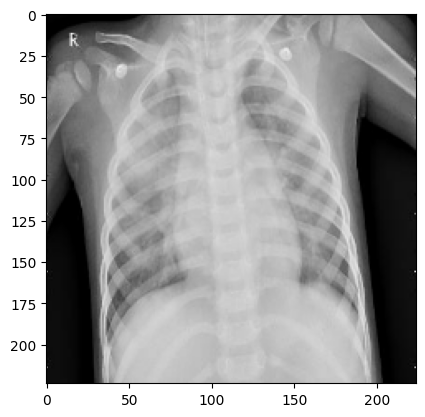

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 20ms/step


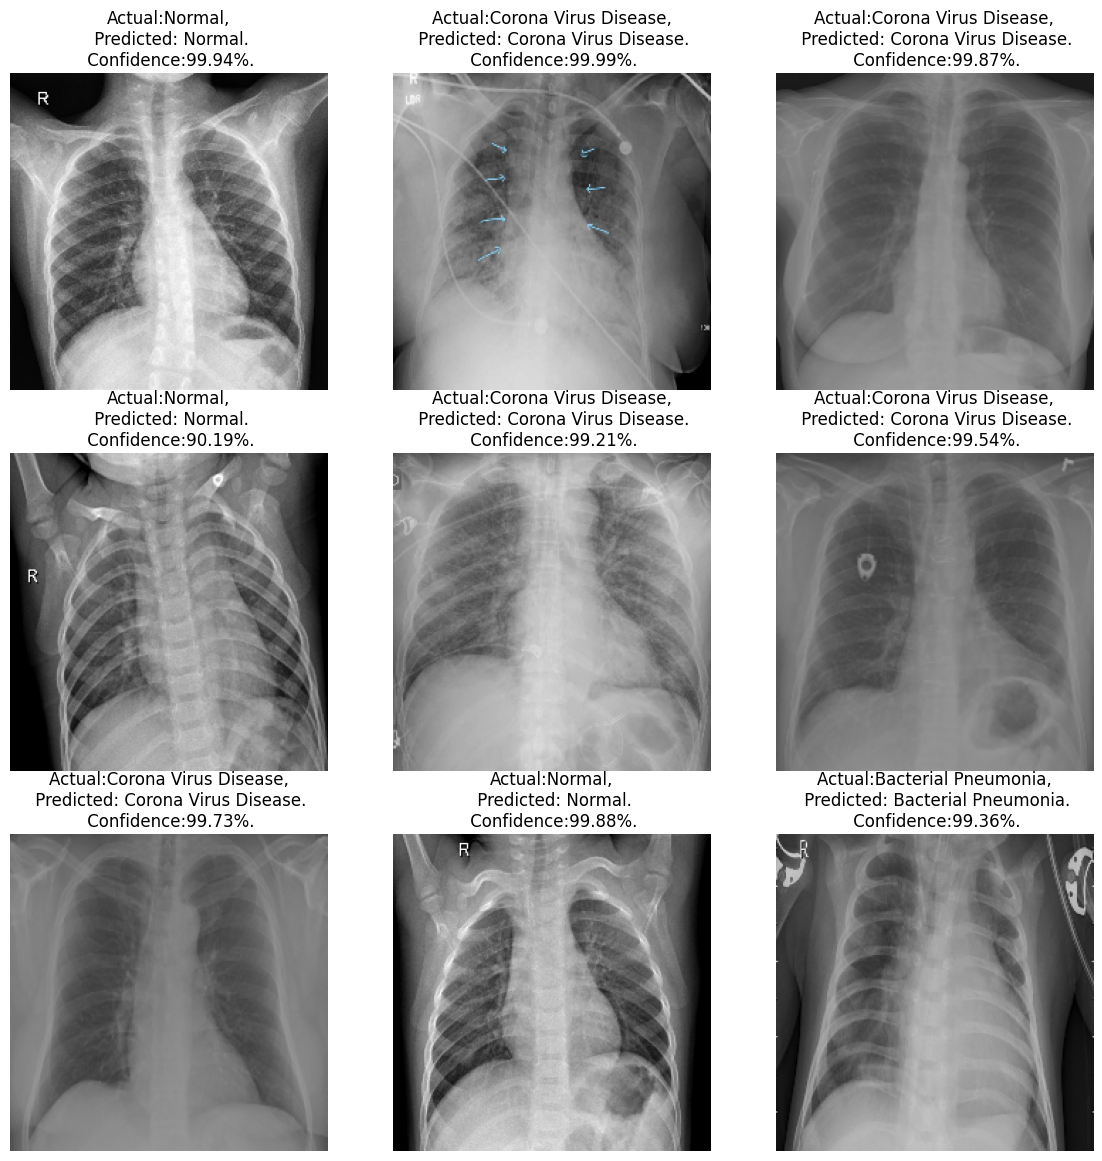

In [ ]:
plt.figure(figsize=(14,14))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%.")
    plt.axis("off")

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('/content/model_saved','wb'))

In [ ]:
model_loaded = pickle.load(open('/content/model_saved','rb'))

In [ ]:
model_loaded.predict(test_ds)

13/13 [==============================] - 0s 19ms/step


array([[1.2707061e-04, 9.9986970e-01, 3.1613231e-06],
       [1.3495834e-03, 4.4890709e-07, 9.9865001e-01],
       [2.5594467e-01, 1.7858701e-04, 7.4387676e-01],
       ...,
       [9.7699499e-01, 2.2578375e-02, 4.2667525e-04],
       [3.9836374e-04, 9.9958676e-01, 1.4850644e-05],
       [2.2848099e-03, 5.1930019e-06, 9.9770999e-01]], dtype=float32)